In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import uproot as ur
import pandas as pd

from os import listdir, mkdir, getcwd
from os.path import isfile, join, basename, isdir

#from convert_directory import convert_directory

In [2]:
source_path = getcwd() # "/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH/"
output_path = join(source_path, ".npy")
in_file_location = "hGen"

In [3]:
type_map = {
    "int32_t": "i4"
}

def convert_type(type_name: str):
    if type_name in type_map:
        return type_map[type_name]
    else:
        return type_name

def convert_file(source_path, in_file_location, output_path = ""):
    with ur.open(source_path) as file:
        # Find data in file
        data = file[in_file_location]

        # Get correct column names and types for conversion
        dtype_arr = []
        dtype_names = data.typenames()

        for field_name in dtype_names:
            dtype_arr.append((field_name, convert_type(dtype_names[field_name])))

        # Convert data to (column-wise) arrays using numpy
        out = np.zeros(data.num_entries, dtype=dtype_arr)
        keys = data.keys()
        for i in range(0, len(keys)):
            key = keys[i]
            out[key] = data[key].array()

        if output_path != "":
            np.save(output_path, out, allow_pickle=True)

    return out

# See https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html
def convert_directory(source_path: str, in_file_location: str, output_dir_abs: str = ""):
    dir_contents = listdir(source_path)
    root_files = filter(lambda filename: filename.endswith(".root"), dir_contents)

    output_dir = source_path
    if output_dir_abs != "":
        output_dir = output_dir_abs

    if not isdir(output_dir_abs):
        mkdir(output_dir_abs)

    for filename in root_files:
        bname = basename(filename)
        output_path = join(output_dir, bname + ".npy")
        if isfile(output_path):
            print("Skipping file <" + bname + "> (exists)")
        else:
            convert_file(join(source_path, filename), in_file_location, output_path)


convert_directory(source_path, "eventTree", output_path)

In [4]:
# Splits a dataframe with separate columns for reco and true properties to one with the properties and a different label "type" with values "true" and "reco" 
def split_event_tree(df,
                     properties=["sigma", "sigmall", "sigmalr", "sigmarl", "sigmarr", "mz", "mhh", "mzhh", "phi", "phif", "phih", "costheta", "costhetaf", "costhetah"],
                     props_shared=["run", "event", "passed_preselection", "m_true_h1_decay_pdg", "m_true_h2_decay_pdg"],
                     type_names=["true", "reco"], column_concat: str ="_"):
    #type_dict = {}
    #for property in properties:
    #    type_dict[property] = pd.Series(dtype=df.dtypes[type_names[0] + column_concat + property])

    # Rename
    rename_dict = {}
    for property in properties:
        rename_dict[type_names[0] + column_concat + property] = property

    df = df.rename(columns=rename_dict)
    df["type"] = type_names[0]

    # Slice and re-add
    for type in type_names:
        if type == type_names[0]:
            continue

        #column_names = [word.replace(type + column_concat, "") for word in ["asd_123", "asd_345"]]
        props_type_specific = list(map(lambda cn: type+column_concat+cn, properties))
        props_slice = props_shared + props_type_specific
        sliced = df.loc[:, props_slice]

        df.drop(columns=props_type_specific, inplace=True)

        rename_dict = {}
        for property in properties:
            rename_dict[type + column_concat + property] = property

        sliced.rename(columns=rename_dict, inplace=True)
        sliced["type"] = type

        df = pd.concat([df, sliced])

    df.reset_index(drop=True, inplace=True)

    return df

In [5]:
b = list(map(lambda e: join(output_path, e), listdir(output_path)))
b

['c:\\DevRepositories\\ZHH\\.npy\\output.root.npy']

In [6]:
data = pd.DataFrame(np.load(b[0], allow_pickle=True))
data.columns

Index(['run', 'event', 'passed_preselection', 'm_true_h1_decay_pdg',
       'm_true_h2_decay_pdg', 'true_sigma', 'true_sigmall', 'true_sigmalr',
       'true_sigmarl', 'true_sigmarr', 'true_mz', 'true_mhh', 'true_mzhh',
       'true_phi', 'true_phif', 'true_phih', 'true_costheta', 'true_costhetaf',
       'true_costhetah', 'reco_sigma', 'reco_sigmall', 'reco_sigmalr',
       'reco_sigmarl', 'reco_sigmarr', 'reco_mz', 'reco_mhh', 'reco_mzhh',
       'reco_phi', 'reco_phif', 'reco_phih', 'reco_costheta', 'reco_costhetaf',
       'reco_costhetah'],
      dtype='object')

In [7]:
data.dtypes

run                      int32
event                    int32
passed_preselection      int32
m_true_h1_decay_pdg      int32
m_true_h2_decay_pdg      int32
true_sigma             float64
true_sigmall           float64
true_sigmalr           float64
true_sigmarl           float64
true_sigmarr           float64
true_mz                float64
true_mhh               float64
true_mzhh              float64
true_phi               float64
true_phif              float64
true_phih              float64
true_costheta          float64
true_costhetaf         float64
true_costhetah         float64
reco_sigma             float64
reco_sigmall           float64
reco_sigmalr           float64
reco_sigmarl           float64
reco_sigmarr           float64
reco_mz                float64
reco_mhh               float64
reco_mzhh              float64
reco_phi               float64
reco_phif              float64
reco_phih              float64
reco_costheta          float64
reco_costhetaf         float64
reco_cos

In [8]:
data.shape

(19900, 33)

In [9]:
data.head()

,run,event,passed_preselection,m_true_h1_decay_pdg,m_true_h2_decay_pdg,true_sigma,true_sigmall,true_sigmalr,true_sigmarl,true_sigmarr,...,reco_sigmarr,reco_mz,reco_mhh,reco_mzhh,reco_phi,reco_phif,reco_phih,reco_costheta,reco_costhetaf,reco_costhetah
0,403001,1,1,5,5,4.069340e-14,3.552943e-15,7.860422e-14,7.876372e-14,1.852726e-15,...,2.235820e-15,91.087692,307.026154,446.901337,-3.079209,1.468088,0.539075,0.658341,-0.736291,0.307948
1,403001,2,1,21,5,7.931965e-14,2.042705e-13,2.737472e-15,2.752175e-15,1.075185e-13,...,1.810879e-15,91.027176,299.286835,425.062439,-1.075820,1.748372,-2.162728,0.002598,-0.502054,0.371653
2,403001,3,1,5,5,2.001587e-14,1.842408e-14,2.597875e-14,2.596317e-14,9.697490e-15,...,1.688653e-14,90.804413,309.041565,483.490875,-1.056400,0.030114,1.773077,0.899296,-0.205217,0.432806
3,403001,4,1,5,24,2.711904e-16,7.092752e-16,1.012994e-18,1.001357e-18,3.734722e-16,...,4.940702e-18,72.563416,367.116302,472.364105,-1.489111,-3.028884,-2.372535,-0.203174,-0.966446,0.906441
4,403001,5,1,5,5,7.656955e-16,1.376326e-17,1.521178e-15,1.520468e-15,7.372861e-18,...,1.599918e-17,81.466057,301.307892,435.992157,2.496945,1.775392,-1.859735,0.643037,0.238666,0.512008


In [10]:
data_split = split_event_tree(data)
data_split

,run,event,passed_preselection,m_true_h1_decay_pdg,m_true_h2_decay_pdg,sigma,sigmall,sigmalr,sigmarl,sigmarr,mz,mhh,mzhh,phi,phif,phih,costheta,costhetaf,costhetah,type
0,403001,1,1,5,5,4.069340e-14,3.552943e-15,7.860422e-14,7.876372e-14,1.852726e-15,90.566605,351.819397,500.236206,-2.859985,1.467834,-2.727943,0.150023,-0.736413,-0.706584,true
1,403001,2,1,21,5,7.931965e-14,2.042705e-13,2.737472e-15,2.752175e-15,1.075185e-13,91.628563,296.155304,424.050720,-1.657698,-1.392957,0.884158,-0.096287,0.492772,-0.505077,true
2,403001,3,1,5,5,2.001587e-14,1.842408e-14,2.597875e-14,2.596317e-14,9.697490e-15,90.209305,315.722168,490.734924,-1.152276,0.045745,-1.333308,0.866910,-0.199558,-0.505704,true
3,403001,4,1,5,24,2.711904e-16,7.092752e-16,1.012994e-18,1.001357e-18,3.734722e-16,72.617577,327.411102,443.476227,0.139058,0.113008,-1.437026,-0.938892,0.966521,-0.418553,true
4,403001,5,1,5,5,7.656955e-16,1.376326e-17,1.521178e-15,1.520468e-15,7.372861e-18,81.175934,343.407288,485.213928,2.420438,1.777578,-2.502799,-0.019200,0.260323,0.303293,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,403001,19896,0,5,5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,reco
39796,403001,19897,1,21,4,1.310379e-14,3.378885e-15,2.363136e-14,2.363237e-14,1.772527e-15,92.152740,365.862579,479.388885,2.601704,2.166908,-1.699798,0.785314,0.615589,0.276387,reco
39797,403001,19898,1,5,5,2.333109e-14,7.227006e-16,4.609974e-14,4.612023e-14,3.816696e-16,92.197929,348.014252,495.750885,2.322969,0.417147,-1.040284,0.876871,0.915175,0.572796,reco
39798,403001,19899,0,5,5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,reco


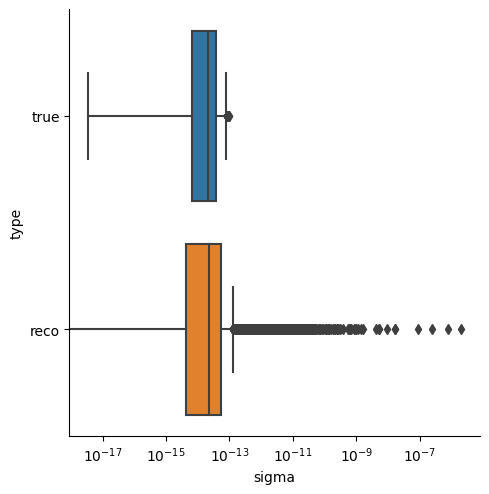

In [11]:
f = sns.catplot(data=data_split, x="sigma", y="type", kind="box")
f.set(xscale="log")

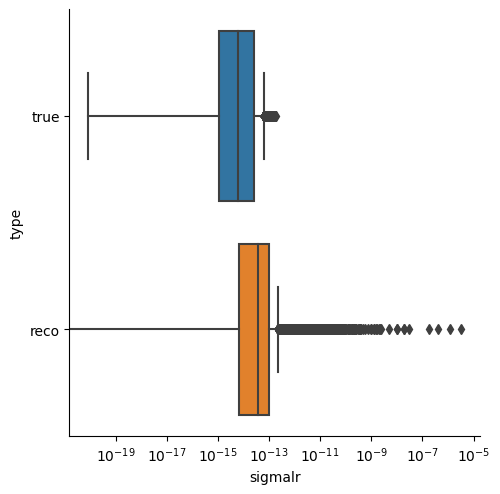

In [12]:
f = sns.catplot(data=data_split, x="sigmalr", y="type", kind="box")
f.set(xscale="log")

[Text(0.5, 1.0, 'Did not pass pre-selection (should be equal)')]

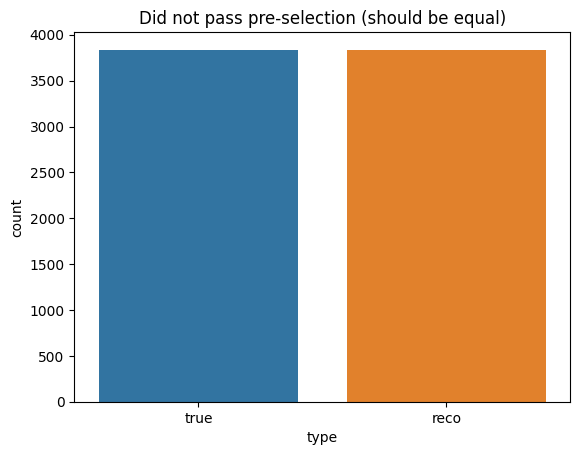

In [13]:
# Did not pass preselection
f = sns.countplot(data=data_split[(data_split["passed_preselection"] == 0)], x="type")
f.set(title="Did not pass pre-selection (should be equal)")

[Text(0.5, 1.0, 'Invalid sigma')]

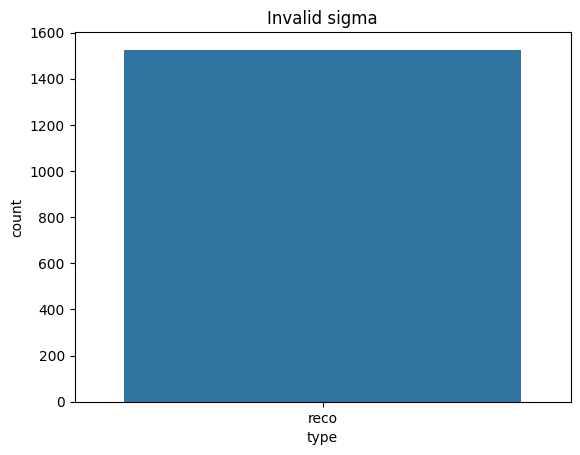

In [14]:
# Invalid sigma
f = sns.countplot(data=data_split[(data_split["sigma"] == 0)], x="type")
f.set(title="Invalid sigma")

[Text(0.5, 1.0, 'Passed pre-selection, but invalid sigma')]

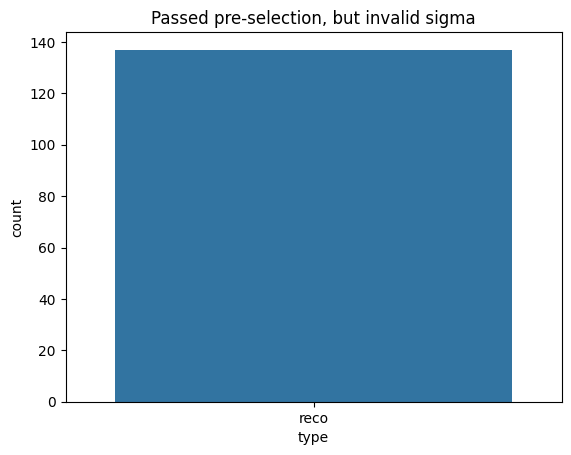

In [15]:
# Passed pre-selection, but still invalid
f = sns.countplot(data=data_split[(data_split["passed_preselection"] == 1) & (data_split["sigma"] == 0)], x="type")
f.set(title="Passed pre-selection, but invalid sigma")

In [16]:
def plot_pplot(title:str, file_prefix:str, data_split):
    f = sns.pairplot(data_split, hue="type", vars=["sigma", "sigmalr", "mz", "phi"], plot_kws=dict( alpha=0.3 ), corner=True)
    f.fig.suptitle(title, y=1.01)

    plt.savefig(file_prefix + "_pairplot.pdf")

def plot_hists(title:str, file_prefix:str, data):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12., 8.)) # layout="constrained"
    fig.suptitle(title)

    cmap = sns.color_palette("Blues", as_cmap=True)

    # Seaborn: unweighted (linear) histograms
    f1 = sns.histplot(data=data, x="true_phi", y="true_mz", bins=(24,256), cbar=True, vmin=0, vmax=250, ax=axs[0][0])
    f1.set(xlim=(-3.142,3.142), ylim=(80,102), title="Unweighted")

    f2 = sns.histplot(data=data, x="reco_phi", y="reco_mz", bins=(24,256), cbar=True, vmin=0, vmax=250, ax=axs[1][0])
    f2.set(xlim=(-3.142,3.142), ylim=(80,102), title="Unweighted")

    # Matplotlib: weighted (log) histograms
    x = "true_phi"
    y = "true_mz"
    counts, xedges, yedges, im = axs[0][1].hist2d(data=data, x=x, y=y, cmap=cmap, bins=(24,16), range=[[-3.142,3.142], [80, 102]], norm="log", weights=1/data["true_sigmalr"])
    fig.colorbar(im, ax=axs[0][1], location='right')

    x = "reco_phi"
    y = "reco_mz"
    counts, xedges, yedges, im = axs[1][1].hist2d(data=data, x=x, y=y, cmap=cmap, bins=(24,16), range=[[-3.142,3.142], [80, 102]], norm="log", weights=1/data["reco_sigmalr"])
    fig.colorbar(im, ax=axs[1][1], location='right')

    fig.tight_layout()
    plt.savefig(file_prefix + "_unwt_vs_wt.pdf")

1. All events / No selection

In [17]:
title = "All events / No preselection"
file_prefix = "1_all_events"
data_current = data

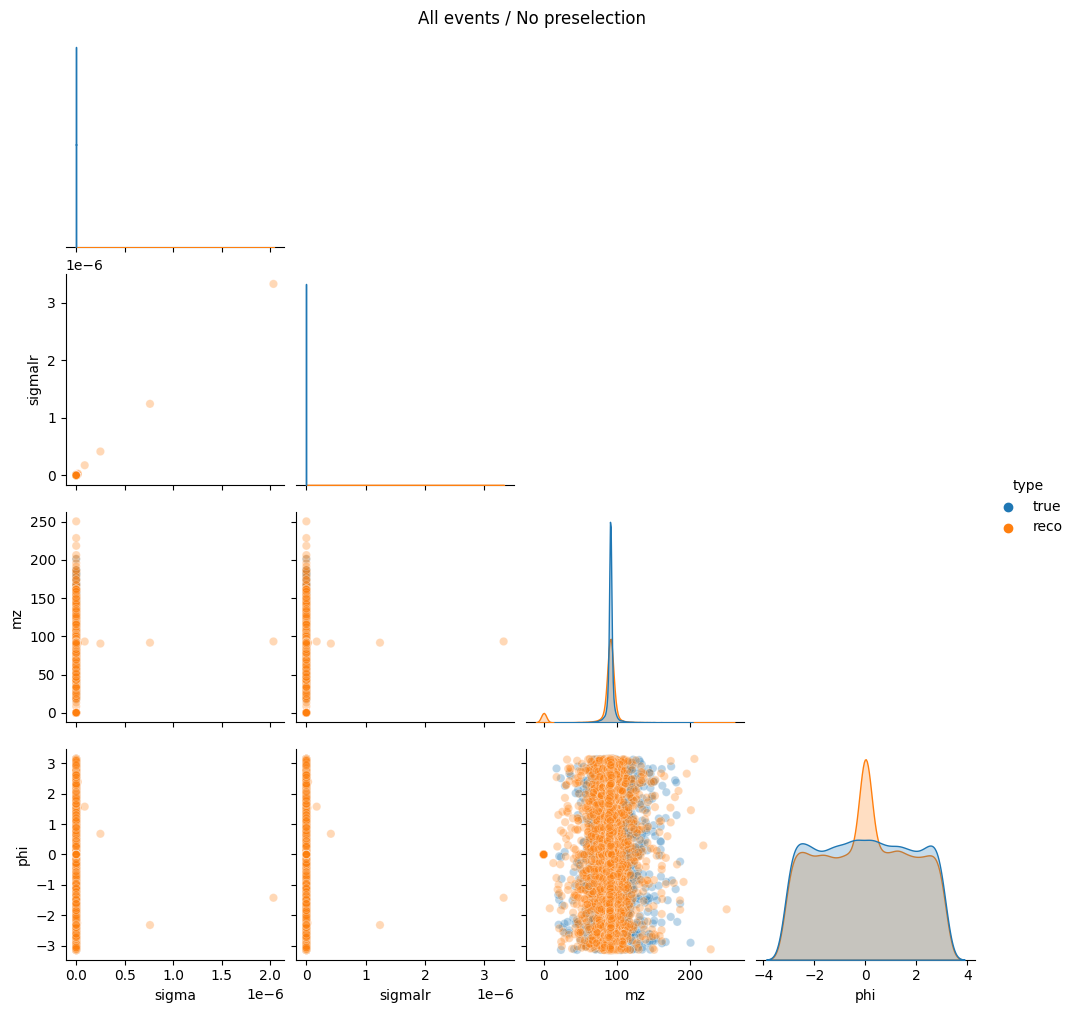

In [18]:
plot_pplot(title, file_prefix, split_event_tree(data_current))

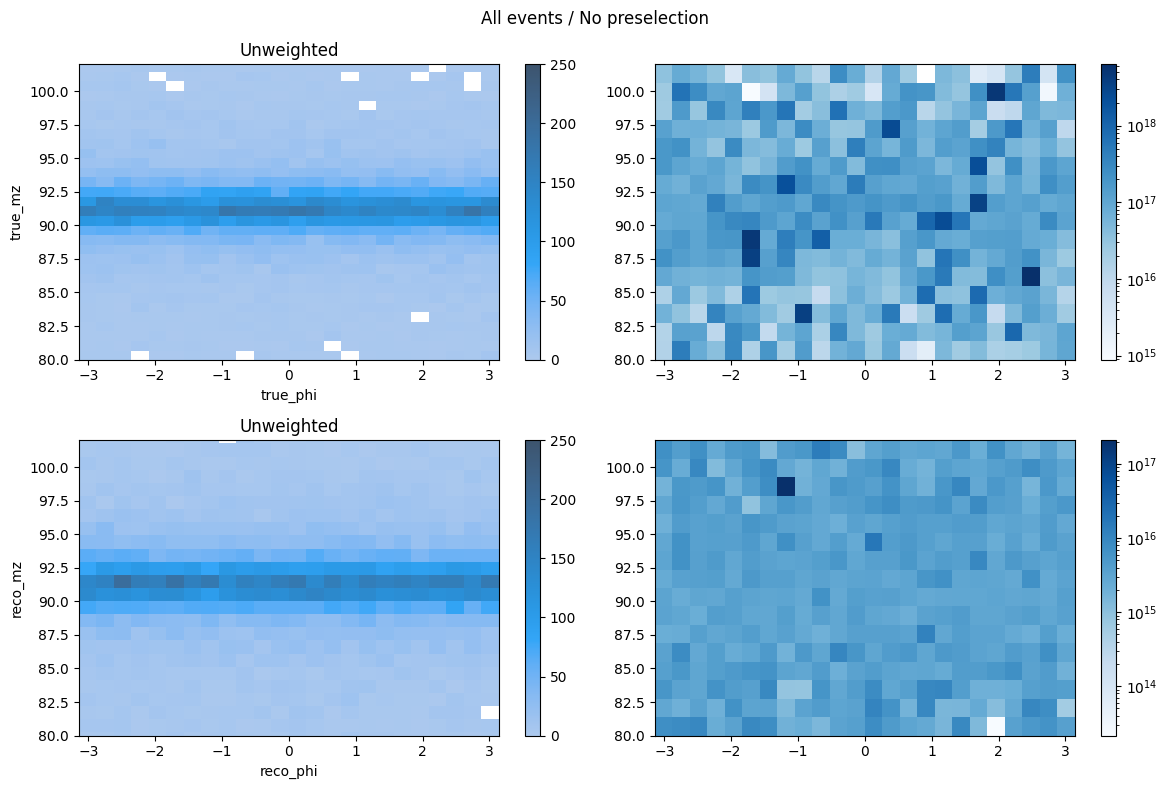

In [19]:
plot_hists(title, file_prefix, data_current)

[(80.0, 102.0), Text(0.5, 1.0, 'ZHH unweighted, both (all events)')]

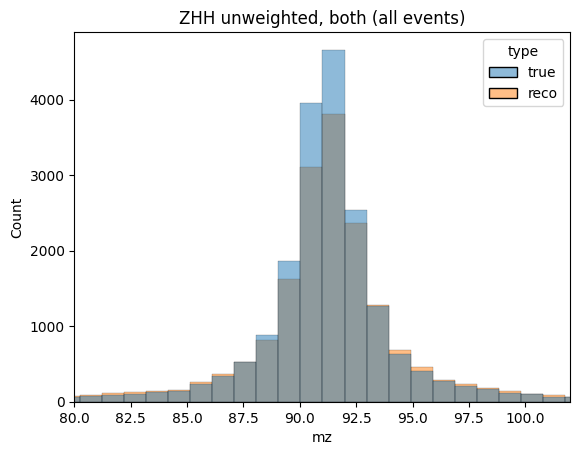

In [20]:
f = sns.histplot(data=data_split, x="mz", bins=256, hue="type", cbar=True)
f.set(xlim=(80,102), title="ZHH unweighted, both (all events)")

In [21]:
np.average(data_split[data_split["type"] == "true"]["sigmalr"])

1.9548625191182865e-14

In [22]:
np.average(data_split[data_split["type"] == "reco"]["sigmalr"])

2.651822206023183e-10

2. Selection A: Passed Pre-Selection (Julie) AND sigma > 0 (Bryan)

In [23]:
title = "Selection A: Passed Pre-Selection AND sigma > 0"
file_prefix = "2_selection_a_passed_presel"
data_current = data[(data["passed_preselection"] == 1) & (data["true_sigma"] > 0) & (data["reco_sigma"] > 0)]

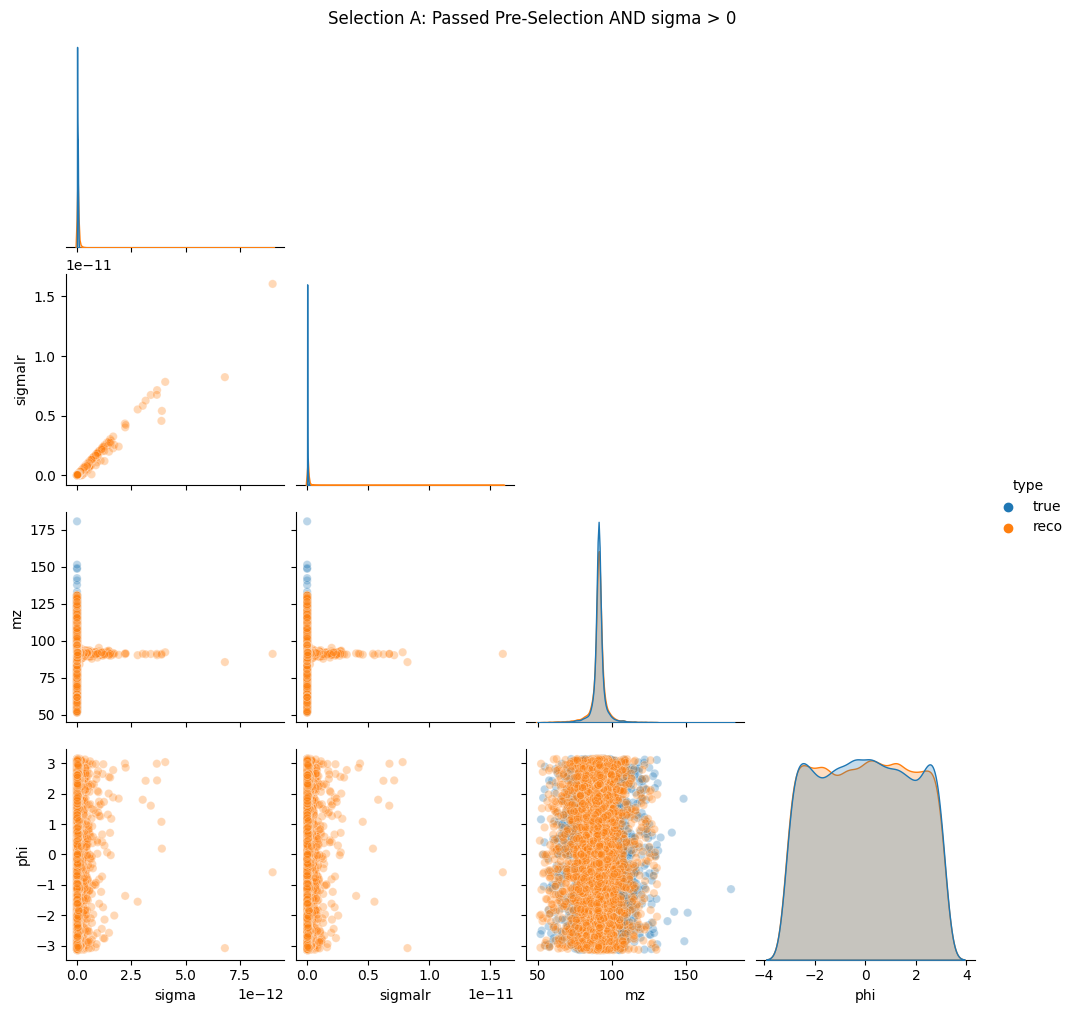

In [24]:
plot_pplot(title, file_prefix, split_event_tree(data_current))

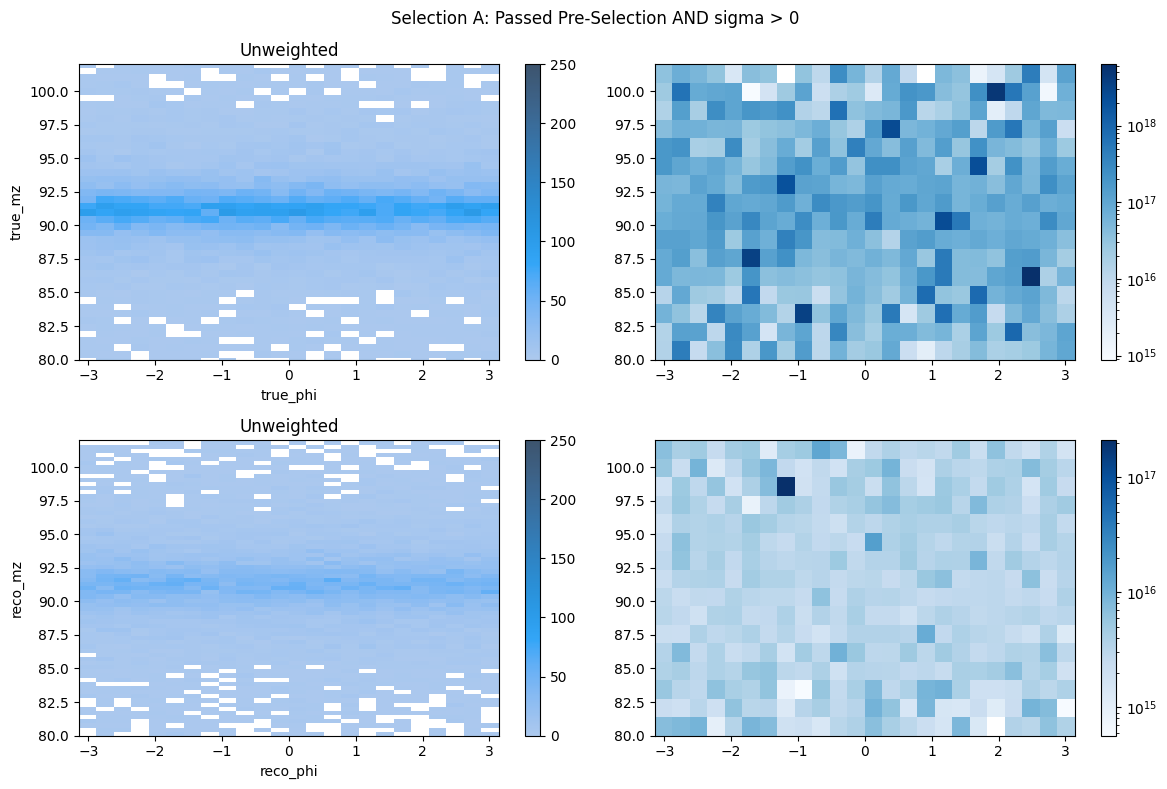

In [25]:
plot_hists(title, file_prefix, data_current)

3. Selection B: Decay to 2b2bbar

In [26]:
title = "Selection B: Decay to 2b2bbar"
file_prefix = "3_selection_b_to_2b2bbar"
data_current = data[(data["m_true_h1_decay_pdg"] == 5) & (data["m_true_h2_decay_pdg"] == 5)]

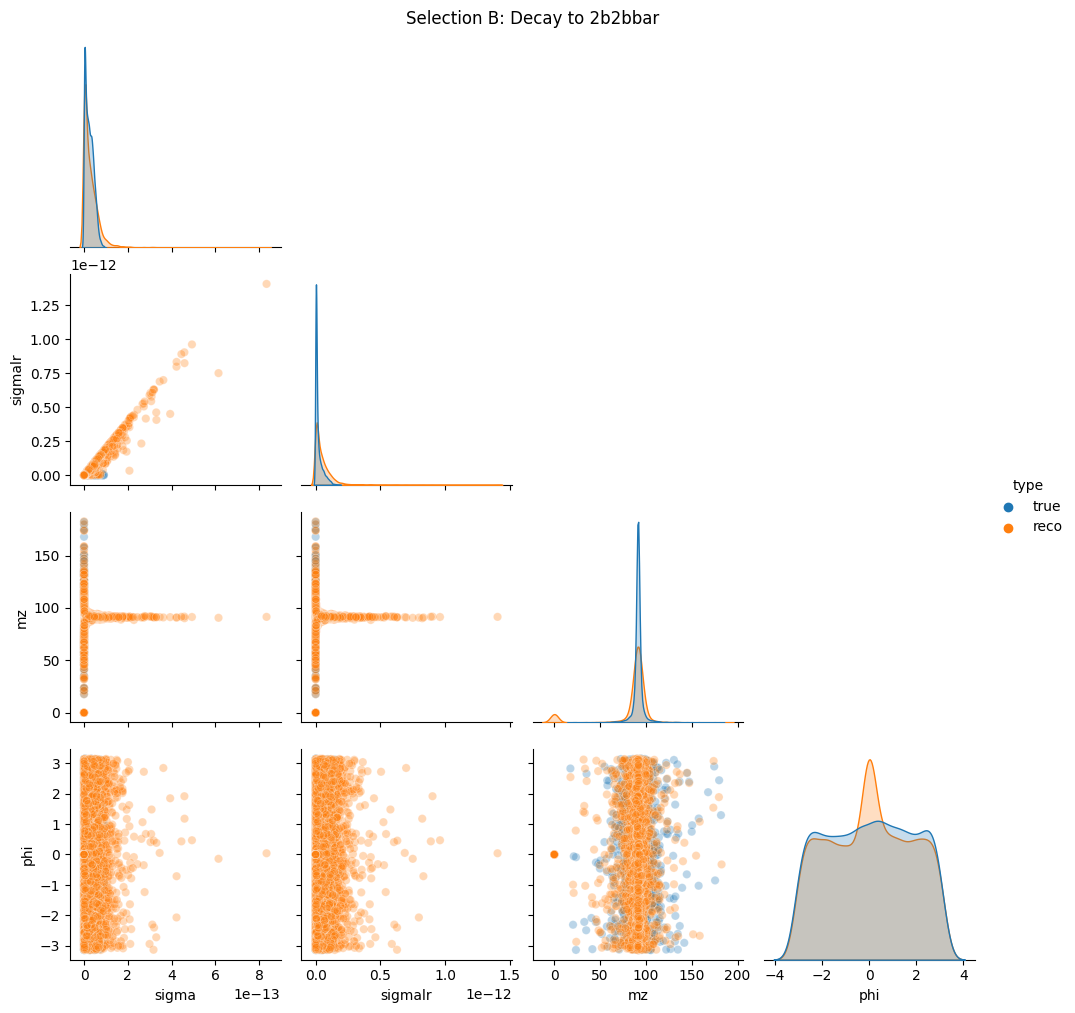

In [27]:
plot_pplot(title, file_prefix, split_event_tree(data_current))

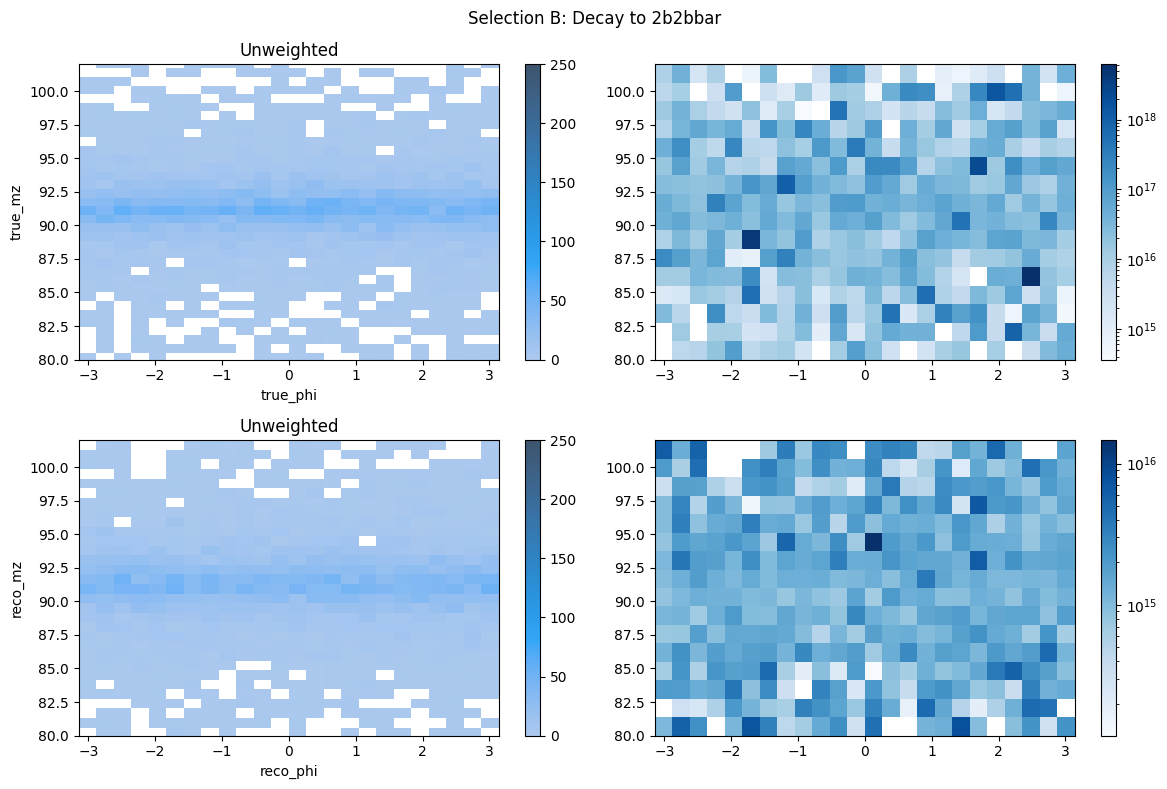

In [28]:
plot_hists(title, file_prefix, data_current)

4. Selection C: Passed Pre-Selection (Julie) AND sigma > 0 (Bryan) AND decay to 2b2bbar

In [29]:
title = "Selection C: Passed Pre-Selection AND Decay to 2b2bbar"
file_prefix = "4_selection_c_passed_presel_and_to_2b2bbar"
data_current = data[(data["passed_preselection"] == 1) & ((data["true_sigma"] > 0) | (data["reco_sigma"] > 0)) & (data["m_true_h1_decay_pdg"] == 5) & (data["m_true_h2_decay_pdg"] == 5)]

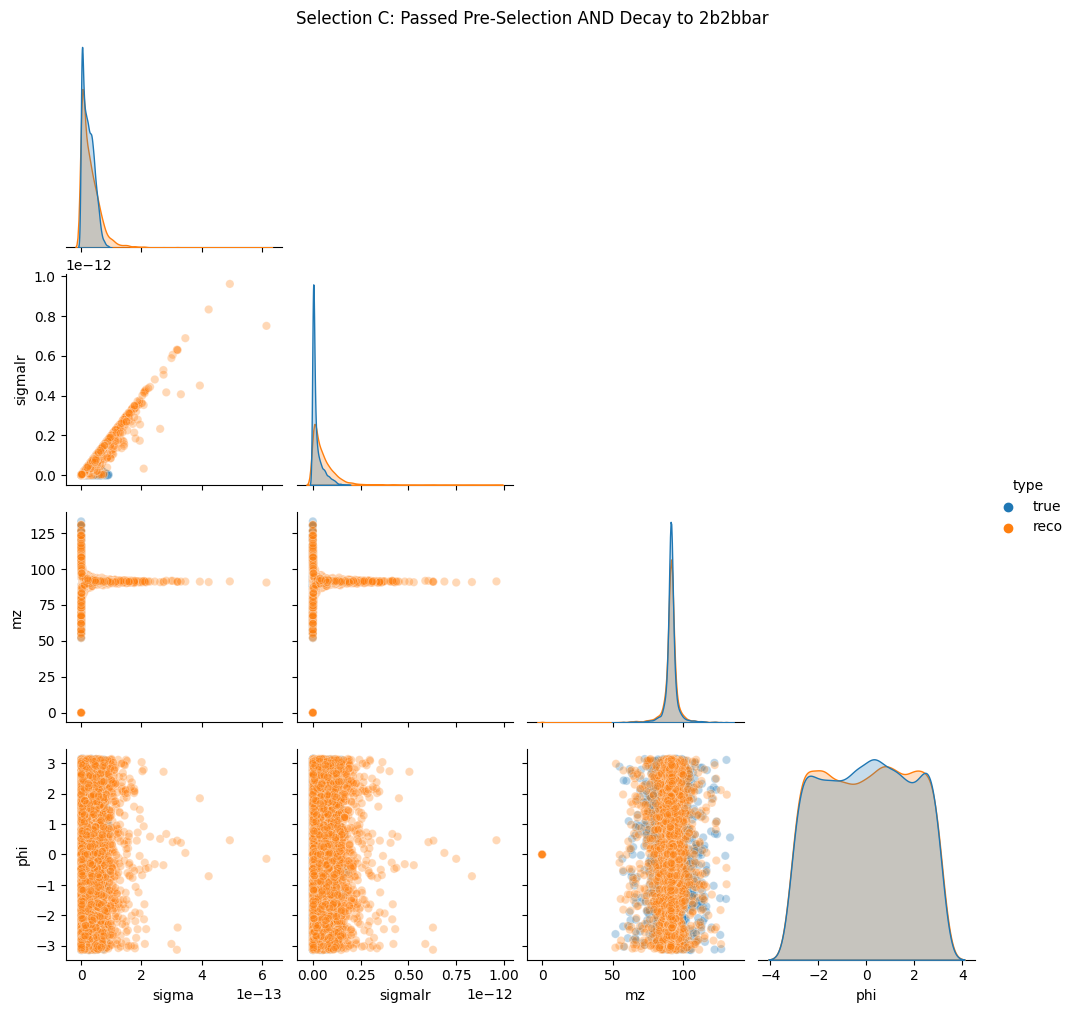

In [30]:
plot_pplot(title, file_prefix, split_event_tree(data_current))

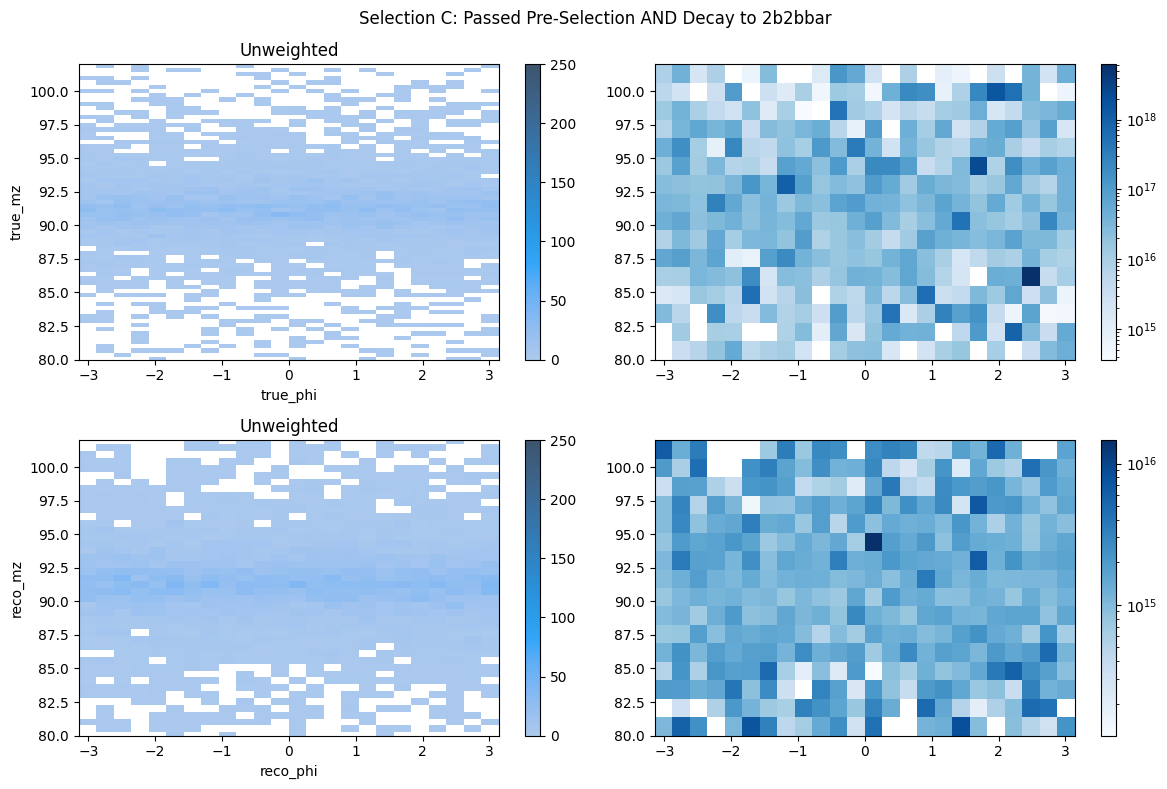

In [31]:
plot_hists(title, file_prefix, data_current)

THE END

In [92]:
data_split[data_split["type"] == "reco"]["sigmalr"]

19900    1.600218e-13
19901    1.555000e-13
19902    4.749192e-14
19903    2.511537e-16
19904    2.571581e-15
             ...     
39795    0.000000e+00
39796    2.363136e-14
39797    4.609974e-14
39798    0.000000e+00
39799    4.446793e-14
Name: sigmalr, Length: 19900, dtype: float64

In [108]:
factor = np.average(data_split[data_split["type"] == "true"]["sigmalr"])/np.average(data_split[data_split["type"] == "reco"]["sigmalr"])
weights = []

for i in range(0, len(data_split)):
    row = data_split.iloc[i]
    weight = row["sigmalr"]

    if row["type"] == "reco":
        weight = weight*factor

    weights.append(0 if weight == 0 else 1/weight)

[Text(0.5, 1.0, 'ZHH weighted, both (all events)')]

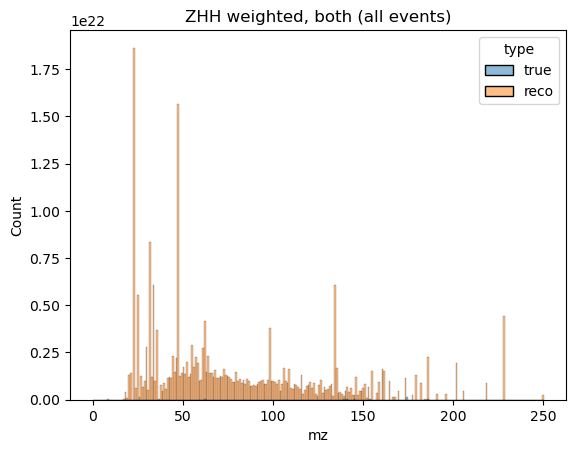

In [109]:
f = sns.histplot(data=data_split, x="mz", bins=256, hue="type", cbar=True, weights=weights)
f.set(title="ZHH weighted, both (all events)")

In [109]:
max(data["reco_phif"])

3.140850067138672

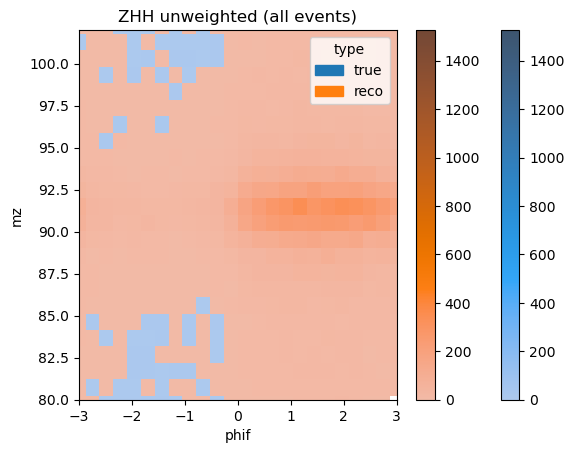

In [99]:
x = "phif"
y = "mz"
f = sns.histplot(data=data_split, x=x, y=y, common_bins=True, bins=(24,256), cbar=True, hue="type")
f.set(xlabel=x, ylabel=y, xlim=(-3.142,3.142), ylim=(80,102), title="ZHH unweighted (all events)")
plt.savefig("1_no_selection_hist_unwt.png")

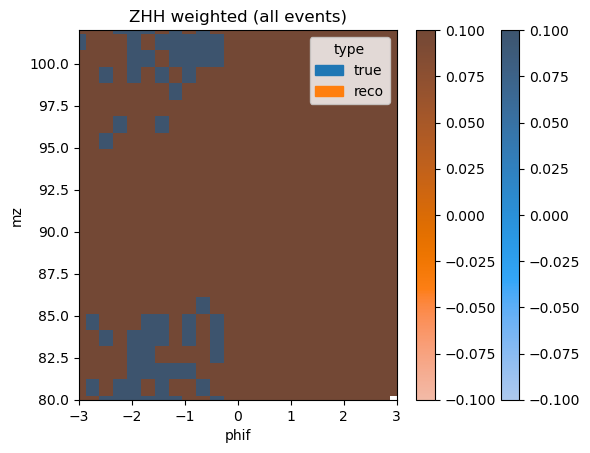

In [101]:
x = "phif"
y = "mz"
f = sns.histplot(data=data_split, x=x, y=y, bins=(24,256), common_bins=True, cbar=True, hue="type", weights=1/data_split["sigmalr"])
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102), title="ZHH weighted (all events)")
plt.savefig("1_no_selection_hist_wt.png")

In [ ]:
x = "phif"
y = "mz"
f = sns.histplot(data=data_split, x=x, y=y, bins=(24,256), cbar=True, weights=1/data_split["sigmalr"])
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102), title="ZHH weighted (all events)")

2. Pass Pre-Selection (and sigma > 0)

Text(0.5, 1.08, 'Passed Pre-Selection (and valid sigma > 0)')

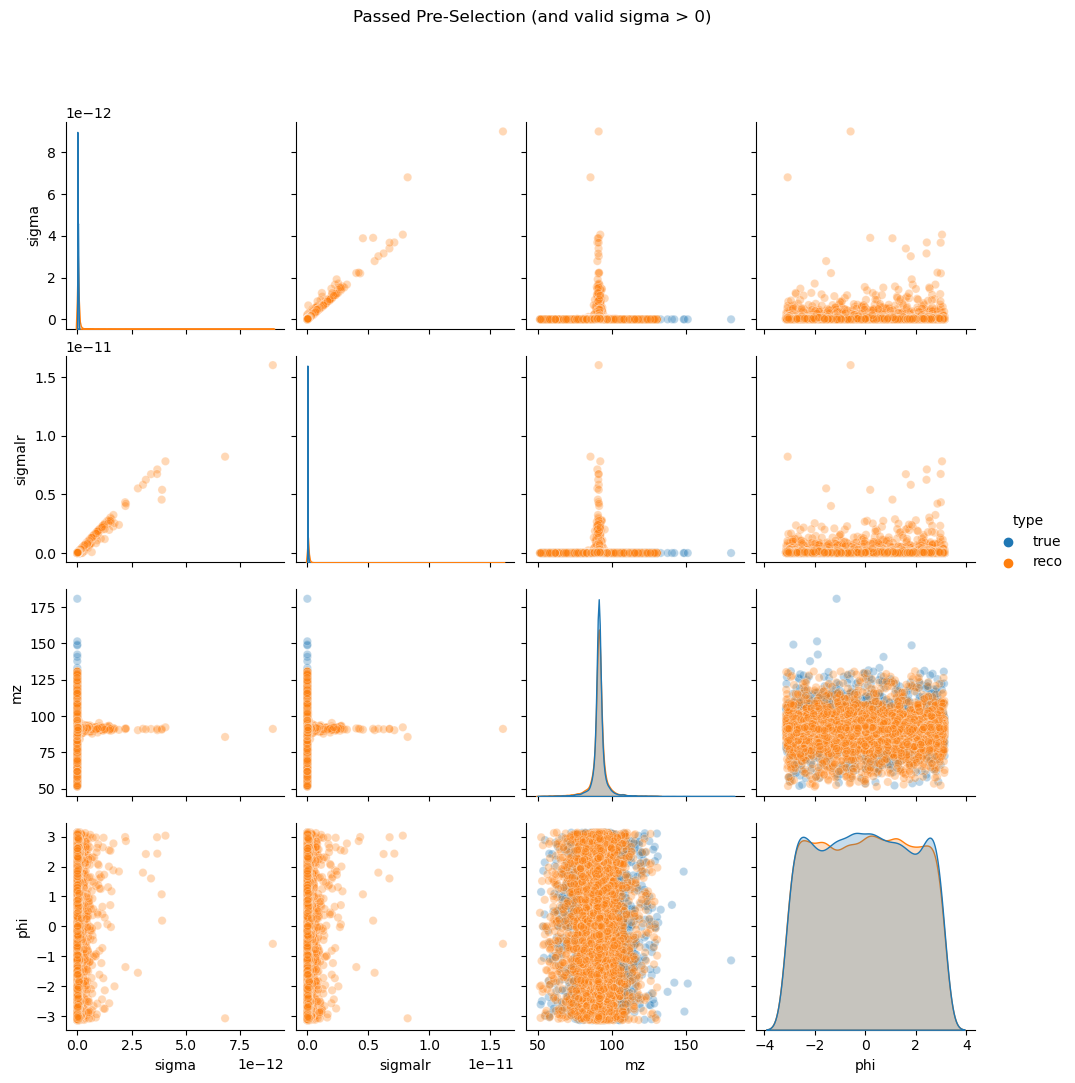

In [22]:
data_split_passed = data_split[(data_split["passed_preselection"] == 1) & (data_split["sigma"] > 0)]

f = sns.pairplot(data_split_passed, hue="type", vars=["sigma", "sigmalr", "mz", "phi"], plot_kws=dict( alpha=0.3 ))
f.fig.suptitle("Passed Pre-Selection (and valid sigma > 0)", y=.5)

In [12]:
print(data_split.shape, data_split_passed.shape)

(39800, 16) (31989, 16)


In [10]:
data[data["reco_sigma"] == 0].shape

(1526, 25)

[Text(0.5, 1.0, 'passed_preselection')]

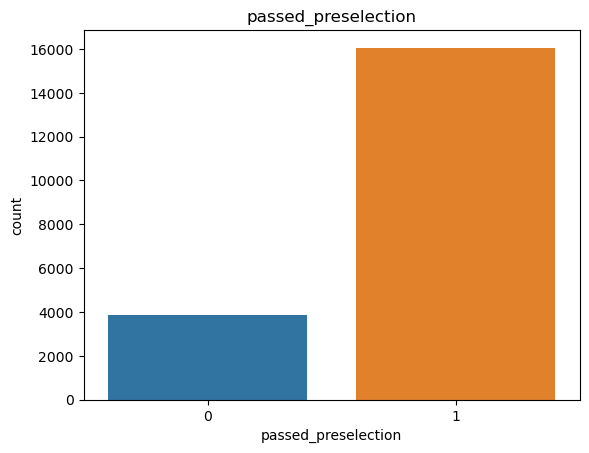

In [114]:
x = "passed_preselection"

#fig, axs = plt.subplots(ncols=3)
#f = sns.countplot(data, x=x1, ax=axs[0])
f = sns.countplot(data, x=x)
f.set(title=x)

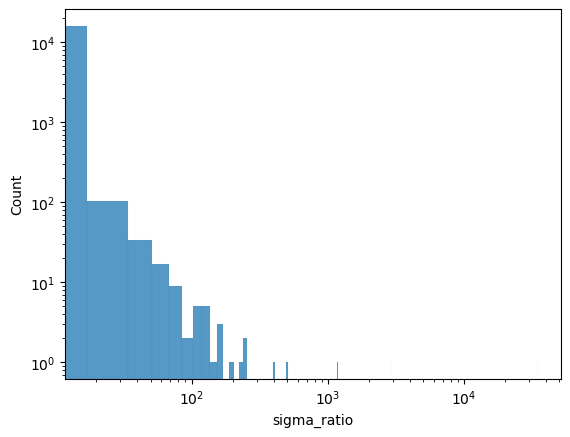

In [141]:
x = "sigma_ratio"

f = sns.histplot(data=data[data["passed_preselection"] == 1], x=x, bins=2048)
f.set_yscale("log")
f.set_xscale("log")

In [116]:
data.head()

,run,event,passed_preselection,m_true_h1_decay_pdg,m_true_h2_decay_pdg,true_sigma,true_sigmall,true_sigmalr,true_sigmarl,true_sigmarr,...,reco_mhh,reco_mzhh,reco_phi,reco_costheta,sigma_ratio,mz_ratio,true_phi_wt,reco_phi_wt,true_mz_wt,reco_mz_wt
0,403001,1,1,5,5,4.069340e-14,3.552943e-15,7.860422e-14,7.876372e-14,1.852726e-15,...,307.026154,446.901337,-3.079209,0.658341,2.008289,1.005754,-3.638463e+13,-1.924244e+13,1.152185e+15,5.692205e+14
1,403001,2,1,21,5,7.931965e-14,2.042705e-13,2.737472e-15,2.752175e-15,1.075185e-13,...,299.286835,425.062439,-1.075820,0.002598,0.996751,0.993437,-6.055578e+14,-6.918456e+12,3.347196e+16,5.853838e+14
2,403001,3,1,5,5,2.001587e-14,1.842408e-14,2.597875e-14,2.596317e-14,9.697490e-15,...,309.041565,483.490875,-1.056400,0.899296,1.798155,1.006597,-4.435455e+13,-2.224379e+13,3.472427e+15,1.911997e+15
3,403001,4,1,5,24,2.711904e-16,7.092752e-16,1.012994e-18,1.001357e-18,3.734722e-16,...,367.116302,472.364105,-1.489111,-0.203174,0.476201,0.999254,1.372745e+17,-5.929084e+15,7.168607e+19,2.889204e+17
4,403001,5,1,5,5,7.656955e-16,1.376326e-17,1.521178e-15,1.520468e-15,7.372861e-18,...,301.307892,435.992157,2.496945,0.643037,1.694688,1.003574,1.591160e+15,9.709764e+14,5.336387e+16,3.167936e+16


[Text(0.5, 0, 'true_phi'), Text(0, 0.5, 'true_mz'), (-3.0, 3.0), (80.0, 102.0)]

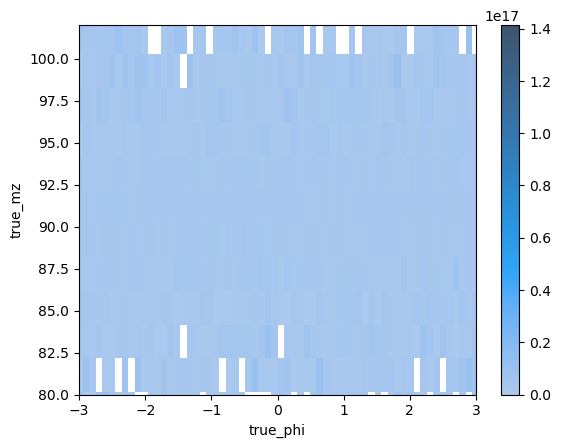

In [126]:
x = "true_phi"
y = "true_mz"

f = sns.histplot(data=data[data["passed_preselection"] == 1], x=x, y=y, bins=(64,64), weights=1/data["true_sigma"], cbar=True)
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102))

[Text(0.5, 0, 'reco_phi'), Text(0, 0.5, 'reco_mz')]

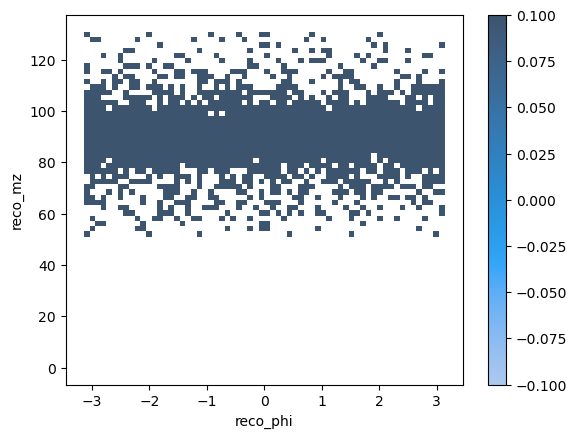

In [128]:
x = "reco_phi"
y = "reco_mz"

f = sns.histplot(data=data[data["passed_preselection"] == 1], x=x, y=y, bins=(64,64), weights=1/data["reco_sigma"], cbar=True)
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102))

AttributeError: PathCollection.set() got an unexpected keyword argument 'cbar'

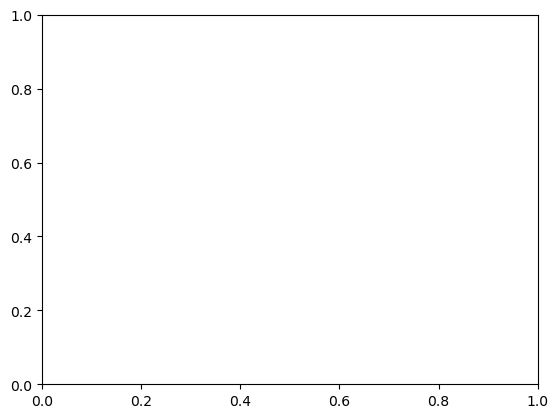

In [122]:
x = "sigmalr_ratio"
y = ""

f = sns.scatterplot(data=data[data["passed_preselection"] == 1], x="reco_sigma", y="true_sigma", cbar=True)
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102))
#f.set(xlim=(10**-12, 1), ylim=(10**-12, 1), yscale="log", xscale="log")

In [1]:
data_zhh = pd.DataFrame(np.load(b[3], allow_pickle=True))
data_zhh["type"] = "zhh"
data_zhh.columns

NameError: name 'pd' is not defined

<Axes: xlabel='actual_zdecay_pdg', ylabel='count'>

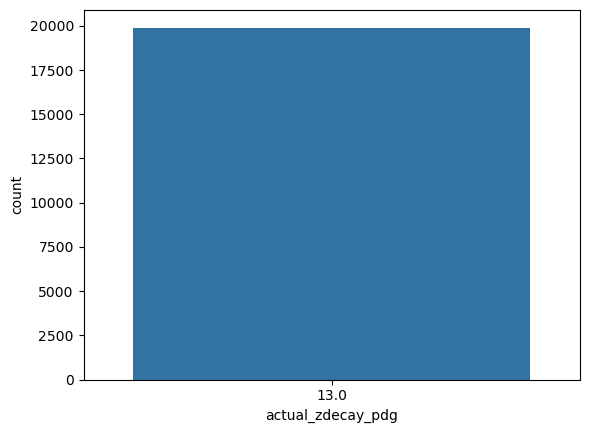

In [84]:
sns.countplot(data_zhh, x="actual_zdecay_pdg")

In [85]:
data = pd.concat([data_zzh, data_zhh])

In [86]:
data.columns

Index(['sigma', 'sigmalll', 'sigmallr', 'sigmalrl', 'sigmalrr', 'sigmarll',
       'sigmarlr', 'sigmarrl', 'sigmarrr', 'mzz', 'mz1', 'mz2', 'mzzh',
       'costheta', 'phi', 'costhetaz', 'phiz', 'costhetaz1f', 'phiz1f',
       'costhetaz2f', 'phiz2f', 'corr_pdgs', 'actual_z1decay_pdg',
       'actual_z2decay_pdg', 'type', 'sigmall', 'sigmarl', 'sigmalr',
       'sigmarr', 'mz', 'mhh', 'mzhh', 'costhetaf', 'phif', 'costhetah',
       'phih', 'actual_zdecay_pdg'],
      dtype='object')

[Text(0.5, 0, 'sigma')]

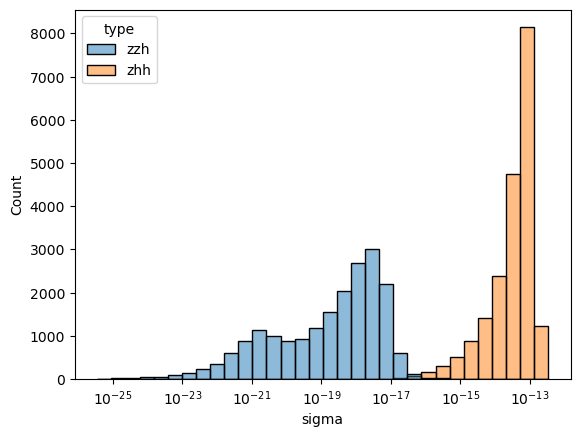

In [87]:
x = "sigma"
f = sns.histplot(data, x=x, hue="type", bins=32, log_scale=True)
f.set(xlabel=x)

[Text(0.5, 0, 'sigma'), Text(0.5, 1.0, 'zhh')]

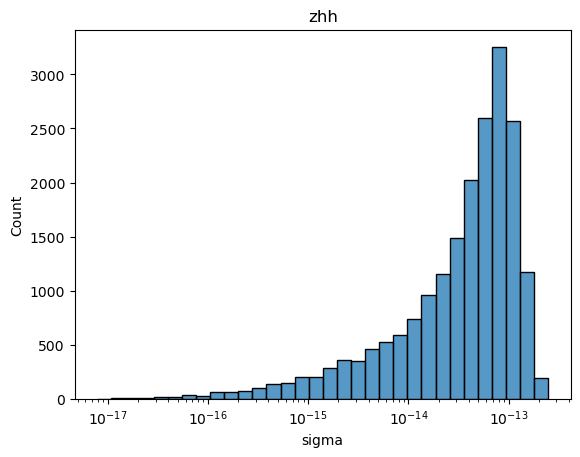

: 

In [88]:
x = "sigma"
f = sns.histplot(data[data["type"] == "zhh"], x="sigma", bins=32, log_scale=True)
f.set(xlabel=x, title="zhh")

[Text(0.5, 0, 'sigma'), Text(0.5, 1.0, 'zzh; assuming Z2 to bbar')]

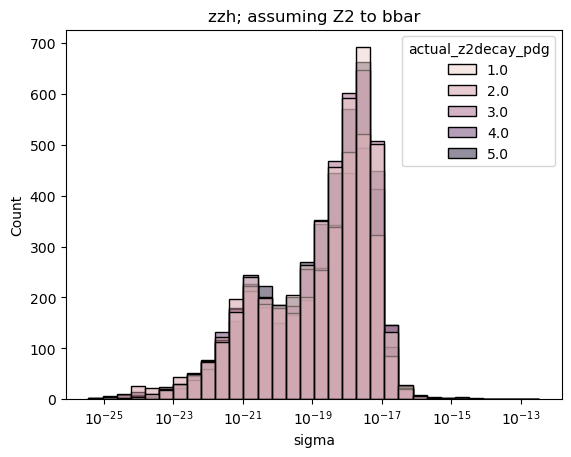

In [56]:
x = "sigma"
f = sns.histplot(data[data["type"] == "zzh"], x="sigma", hue="actual_z2decay_pdg", bins=32, log_scale=True)
f.set(xlabel=x, title="zzh; assuming Z2 to bbar")

[Text(0.5, 0, 'sigma'), Text(0.5, 1.0, 'zzh mz1,mz2')]

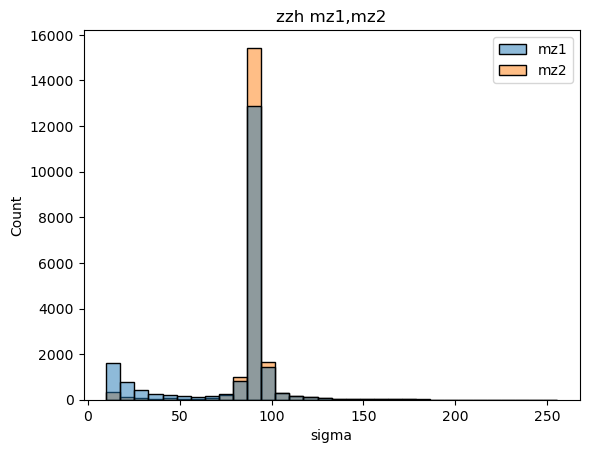

In [76]:
x = "sigma"
y = ["mz1", "mz2"]
f = sns.histplot(data[data["type"] == "zzh"][y], bins=32)
f.set(xlabel=x, title="zzh " + ",".join(y))

[Text(0.5, 0, 'mz1'), Text(0.5, 1.0, 'zzh; assuming Z2 to bbar'), None]

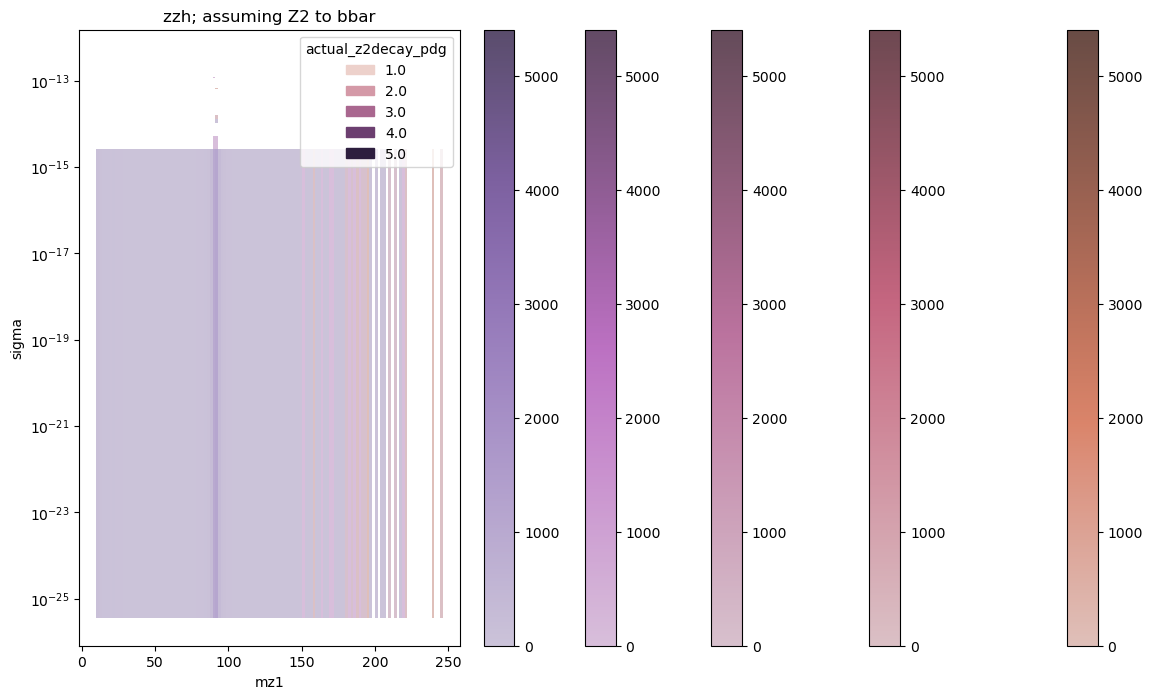

In [74]:
x = "mz1"
y = "sigma"

plt.figure(figsize=(15,8))
f = sns.histplot(data[data["type"] == "zzh"], x=x, y=y, hue="actual_z2decay_pdg", bins=128, cbar=True)
f.set(xlabel=x, title="zzh; assuming Z2 to bbar", yscale="log")

[Text(0.5, 0, 'mz'), Text(0.5, 1.0, 'Pe2e2hh.eL.pR / ZHH')]

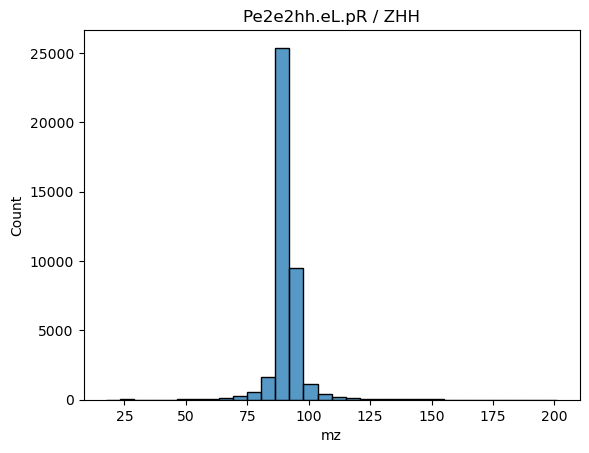

In [59]:
x = "mz"
f = sns.histplot(x=data[x], bins=32)
f.set(xlabel=x, title="Pe2e2hh.eL.pR / ZHH")

[Text(0.5, 0, 'mhh'), Text(0.5, 1.0, 'Pe2e2ffqqH.eL.pR / ZHH')]

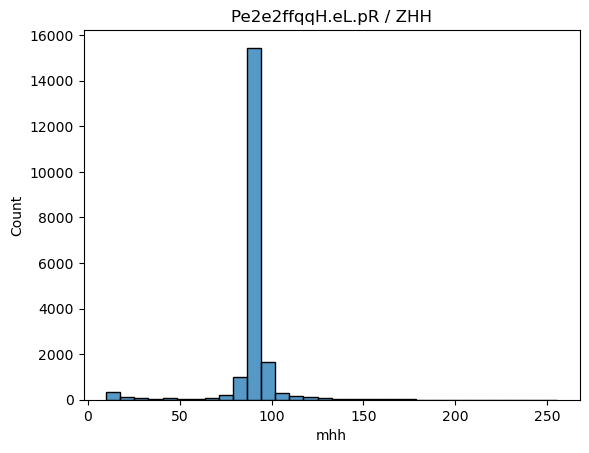

In [15]:
x = "mhh"
f = sns.histplot(x=data[x], bins=32)
f.set(xlabel=x, title="Pe2e2ffqqH.eL.pR / ZHH")

[Text(0.5, 0, 'phif'),
 Text(0, 0.5, 'mz'),
 (-3.0, 3.0),
 (80.0, 102.0),
 Text(0.5, 1.0, 'Pe2e2hh.eL.pR / ZHH unweighted')]

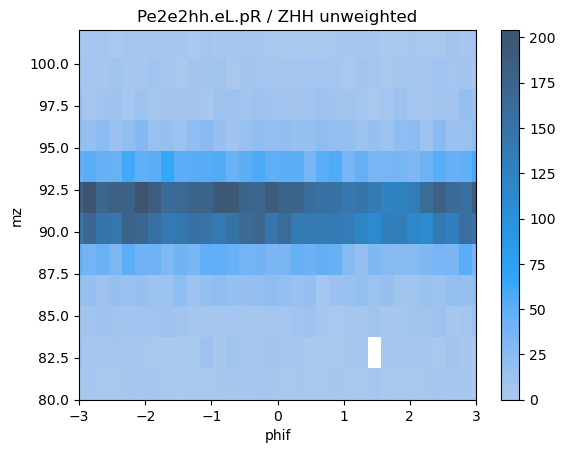

In [16]:
x = "phif"
y = "mz"
f = sns.histplot(x=data[x], y=data[y], bins=(32,128), cbar=True)
f.set(xlabel=x, ylabel=y, xlim=(-3,3), ylim=(80,102), title="Pe2e2hh.eL.pR / ZHH unweighted")

[Text(0.5, 0, 'sigmalr'), Text(0.5, 1.0, 'Pe2e2hh.eL.pR'), None]

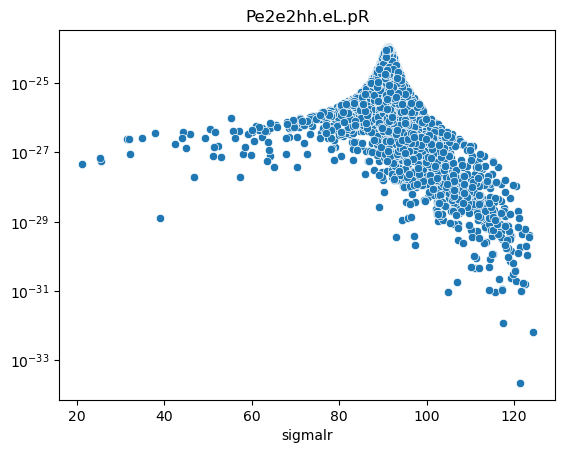

In [34]:
x = "sigmalr"
f = sns.scatterplot(x=data_old["mz"], y=data_old[x])
f.set(xlabel=x, title="Pe2e2hh.eL.pR", yscale="log")

[Text(0.5, 0, 'sigmalr'), Text(0.5, 1.0, 'Pe2e2hh.eL.pR'), None]

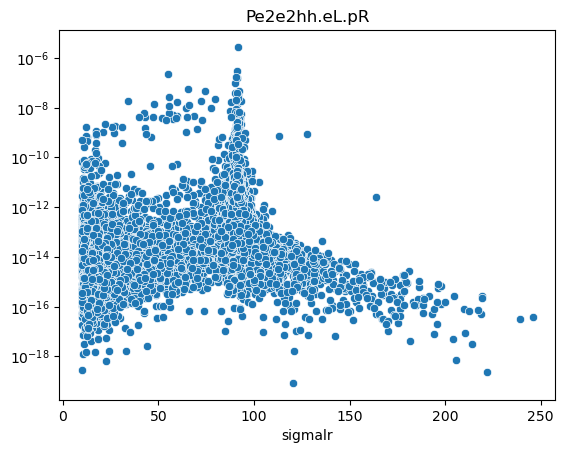

In [35]:
x = "sigmalr"
f = sns.scatterplot(x=data["mz"], y=data[x])
f.set(xlabel=x, title="Pe2e2ffqqh.eL.pR CORRECT", yscale="log")

[Text(0.5, 0, 'sigmalr'), Text(0.5, 1.0, 'Pe2e2ffqqh.eL.pR CORRECT'), None]

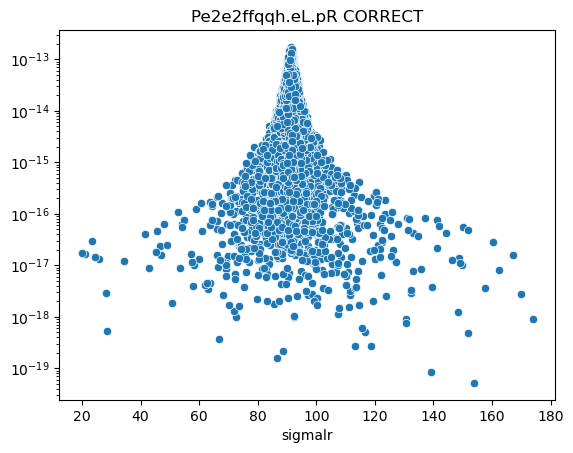

In [37]:
x = "sigmalr"
f = sns.scatterplot(x=data_inv["mz"], y=data_inv[x])
f.set(xlabel=x, title="Pe2e2ffqqh.eL.pR CORRECT", yscale="log")

[Text(0.5, 0, 'phif'),
 Text(0, 0.5, 'mz'),
 Text(0.5, 1.0, 'Pe2e2hh.eL.pR / ZHH weighted by sigmalr')]

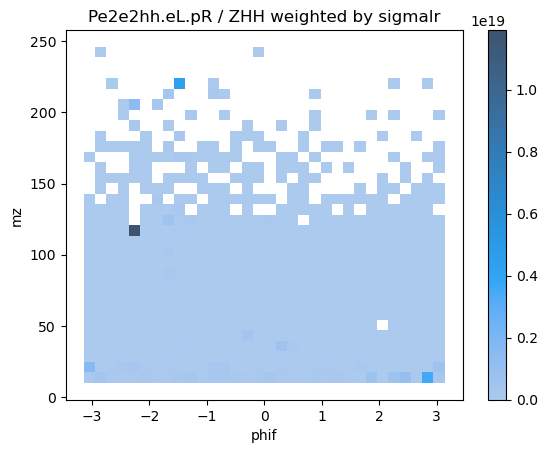

In [13]:
x = "phif"
y = "mz"
weight = "sigmalr"
f = sns.histplot(x=data[x], y=data[y], bins=32, cbar=True, weights=1/data[weight])
f.set(xlabel=x, ylabel=y, title="Pe2e2hh.eL.pR / ZHH weighted by " + weight)